### Importing the Dependencies

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os 

### Data Collection

In [2]:
calories = pd.read_csv('calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [3]:
exercise_data = pd.read_csv('exercise.csv')
exercise_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


#### Combining the two Dataframes

In [4]:
#Merging two datasets using User_ID
calories_data = exercise_data.merge(calories, on="User_ID")
calories_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [5]:
#Check final dataset
calories_data.shape

(15000, 9)

In [6]:
#Check dataset info 
calories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


### Processing

#### Check for missing values

In [7]:
calories_data.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

#### Encode gender column that is object type

In [8]:
le = LabelEncoder()
calories_data['Gender'] = le.fit_transform(calories_data['Gender'])

#### Statistical summary

In [9]:
calories_data.describe()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,0.496467,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,0.500004,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,0.000000,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,0.000000,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,1.000000,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


- We can see down bellow that regarding gender we have almost balanced dataset with pretty equal man and women group. 

- Ages vary from 20 years old to 79 years old with median 39 years old that indicate mix of young and older adults skewing little bit towards middle aged patients

- The wide standard deviation in height and weight suggest diversity in body types 

- I verified there were no missing values in the dataset based on consistent counts across all columns

- The calorie burn shows a high standard deviation, so I might explore normalization or binning for modeling

- Heart rate and body temp being correlated with duration could be interesting for feature engineering or predictive modeling

- Outliers are possible — for example, 1 minute duration or 314 calories — I’d visualize this with boxplots or histograms

#### Plot gender

<Axes: xlabel='Gender', ylabel='count'>

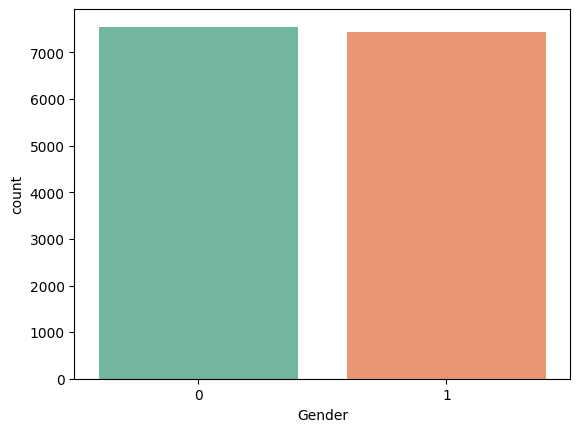

In [10]:
sns.countplot(data=calories_data, x='Gender', hue='Gender', palette='Set2', legend=False)

<Axes: xlabel='Age', ylabel='Count'>

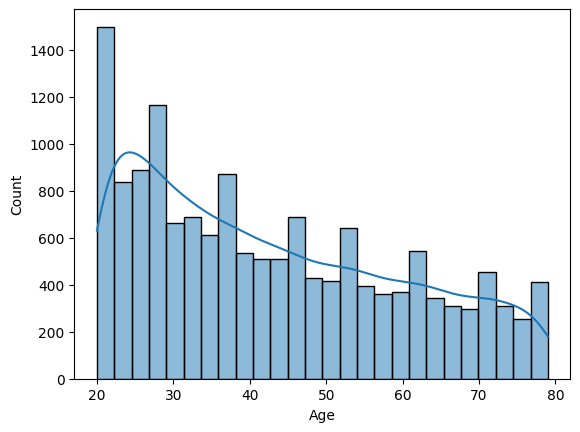

In [11]:
###Check distributions for age,weight and Height
sns.histplot(calories_data['Age'], kde=True)

<Axes: xlabel='Height', ylabel='Count'>

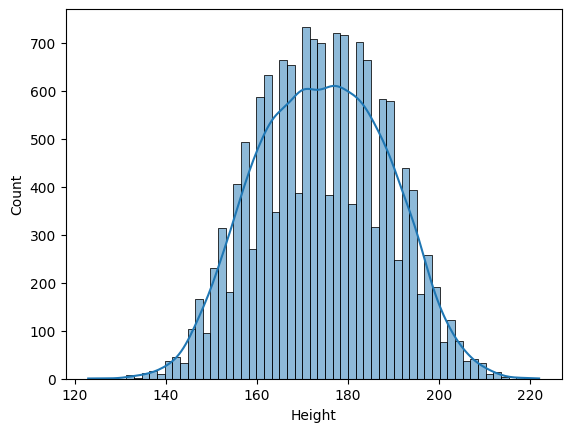

In [12]:
sns.histplot(calories_data['Height'], kde=True)

<Axes: xlabel='Weight', ylabel='Count'>

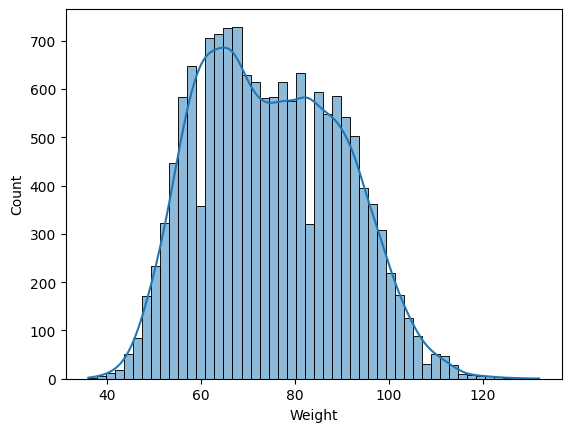

In [13]:
sns.histplot(calories_data['Weight'], kde=True)

#### CORELATION HEATMAP

- Shows how strongly features are linearly correlated 

- Helps detect multicollinearity and strongest predictors of Calories

Feature correlation with Calories:
 Calories      1.000000
Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Gender        0.022357
Height        0.017537
User_ID      -0.001661
Name: Calories, dtype: float64


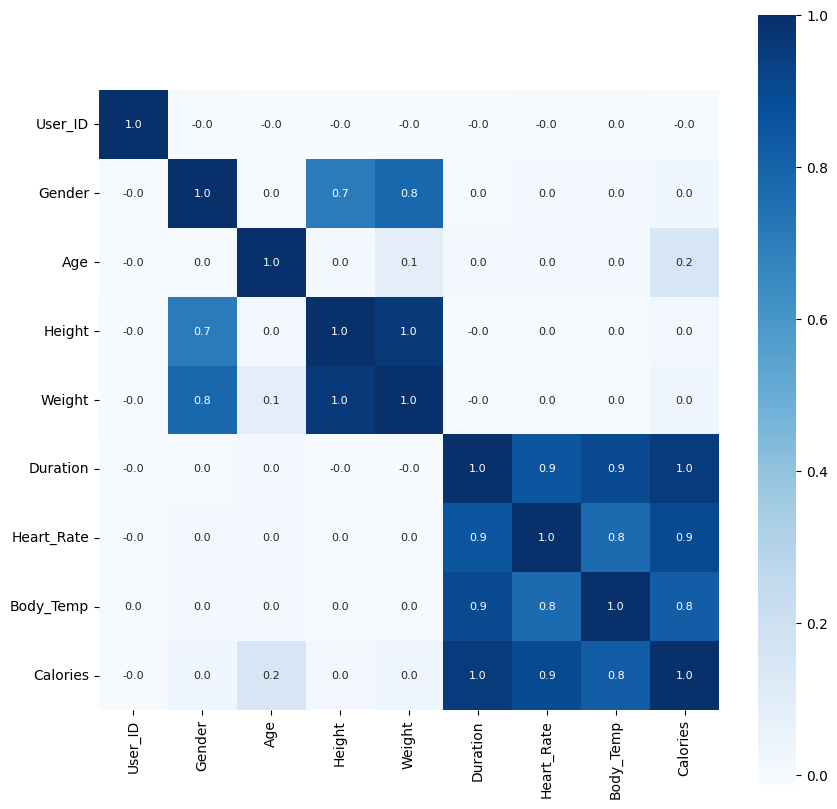

In [14]:
correlation = calories_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')
corr_target = correlation['Calories'].sort_values(ascending=False)
print("Feature correlation with Calories:\n", corr_target)

### Feature target split

In [15]:
#User_ID excluded, not predictive
X = calories_data.drop(columns=['User_ID', 'Calories'], axis=1)
Y = calories_data['Calories']

### Train-Test split 

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

### Create model 

In [17]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, Y_train)
print(model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)


### Predictions

In [18]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

### Evaluate Model

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
r2 = r2_score(Y_test, test_predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 1.51
Root Mean Squared Error (RMSE): 2.14
R-squared (R²): 1.00


#### Residuals distribution plot 

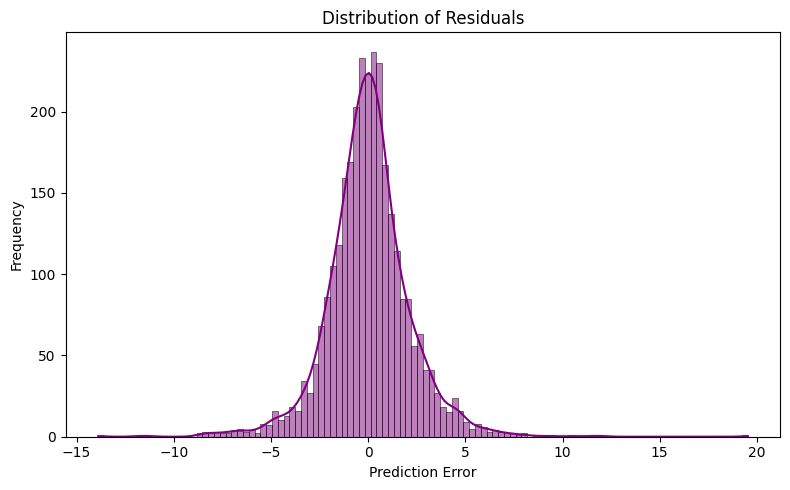

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot residuals (actual - predicted)
residuals = Y_test - test_predictions

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Actual vs Predicted scatter plot 

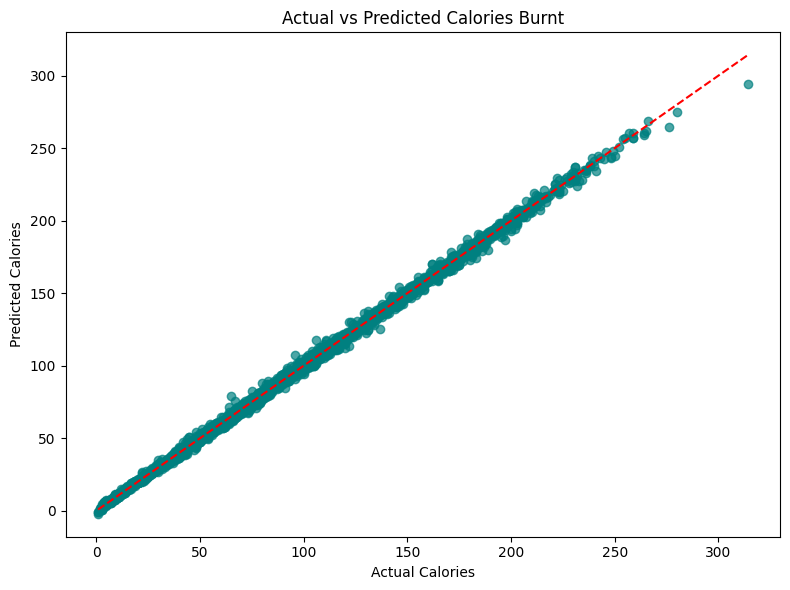

In [21]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(Y_test, test_predictions, alpha=0.7, color="teal")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red')
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted Calories Burnt")
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Grid definition
param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [3, 5, 7, 10],               
    'learning_rate': [0.01, 0.05, 0.1],       
    'subsample': [0.6, 0.8, 1.0],                  
    'gamma': [0, 0.1, 0.3],                                 
}

# Build all combinations
grid = list(ParameterGrid(param_grid))
print(f"Total combinations: {len(grid)}")

# Manually run grid search with tqdm
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in tqdm(grid, desc="Tuning"):
    model = XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1, random_state=42)

    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = mean_absolute_error(y_val, preds)
        scores.append(score)

    avg_score = np.mean(scores)
    results.append((params, avg_score))

# Sort results by lowest MAE
sorted_results = sorted(results, key=lambda x: x[1])
best_params, best_score = sorted_results[0]

print("\nBest Parameters:", best_params)
print("Best MAE:", best_score)


Total combinations: 324


Tuning: 100%|████████████████████████████████████████████████████████████████████████| 324/324 [13:08<00:00,  2.44s/it]


Best Parameters: {'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6}
Best MAE: 1.0056193298002083


#### Save Best Model

In [36]:
# Ensure directory exists
os.makedirs("models", exist_ok=True)

# Save the model inside the models/ directory
joblib.dump(final_model, "models/best_xgb_model.pkl")
print("Model saved to models/best_xgb_model.pkl")


Model saved to models/best_xgb_model.pkl


In [31]:
# Retrain best model on full training set
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, Y_train)

final_preds = final_model.predict(X_test)

# Final evaluation
from sklearn.metrics import mean_squared_error, r2_score

print("Final MAE:", mean_absolute_error(Y_test, final_preds))
print("Final RMSE:", np.sqrt(mean_squared_error(Y_test, final_preds)))
print("Final R²:", r2_score(Y_test, final_preds))


Final MAE: 0.8920670167158047
Final RMSE: 1.3863621244832707
Final R²: 0.9995106470947854


#### “After tuning XGBoost using GridSearchCV, I achieved an MAE of 0.89, which means my predictions are less than one calorie off on average. The R² score of 0.9995 indicates a nearly perfect fit. These results are consistent across cross-validation folds and confirmed by residual analysis.”

### Residuals of Best Model

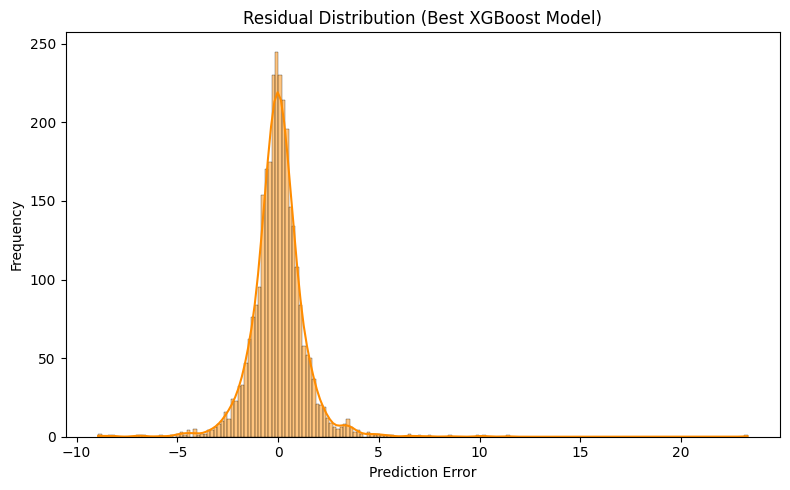

In [32]:
# Residuals from the best model
final_residuals = Y_test - final_preds

plt.figure(figsize=(8,5))
sns.histplot(final_residuals, kde=True, color="darkorange")
plt.title("Residual Distribution (Best XGBoost Model)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Actual vs Predicted for Best Model

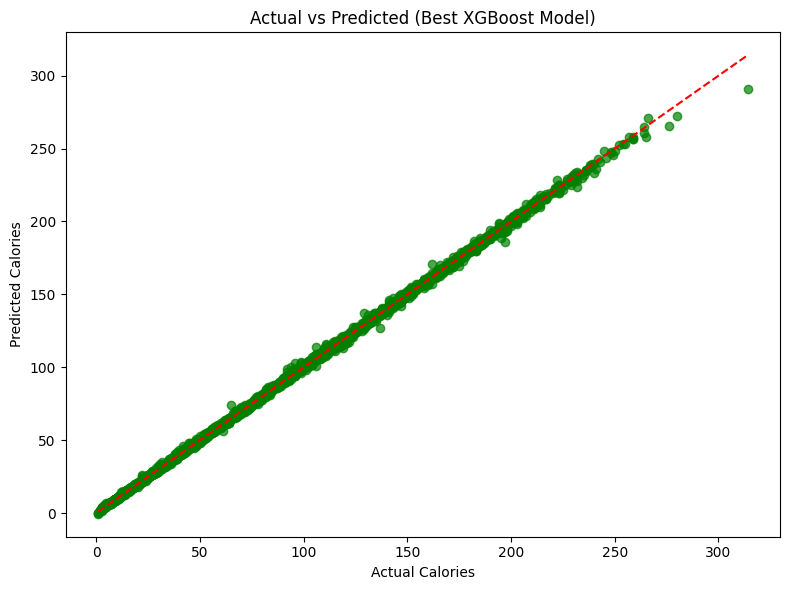

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, final_preds, alpha=0.7, color="green")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red')
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted (Best XGBoost Model)")
plt.tight_layout()
plt.show()
